In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

from datetime import datetime
plt.rcParams["font.family"] = "Arial"

In [2]:
import os
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss/1e6)

161.153024


# 1. calculate

In [3]:
all_data = np.load('../2_intp_monthly/out_monthly_combine.npy')
print(all_data.shape)
print(process.memory_info().rss/1e6)

(1427688, 442)
2685.353984


In [4]:
occr_area_storage = pd.read_parquet('../3_occr_dem/out_2_occr_area_storage.parquet') \
                      .sort_values('hylak_id').reset_index(drop=True)
display(occr_area_storage.head(3))
display(len(occr_area_storage))
print(process.memory_info().rss/1e6)

,hylak_id,final_g,final_v,final_a,final_s
0,1,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[-25.882875061035158, -25.900460052490235, -25...","[382013.636608, 381476.37248, 381157.015552, 3...","[4560144.881206199, 4553427.174670724, 4540449..."
1,2,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[160.22321472167968, 160.4760986328125, 160.78...","[30818.39616, 30816.272384, 30814.564352, 3081...","[153875.59995596876, 153875.59995596876, 15387..."
2,3,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[159.3858154296875, 159.15634155273438, 159.02...","[27278.729216, 27270.629376, 27264.612352, 272...","[94988.85411914224, 88729.09836759193, 85024.7..."


1273379

9949.0816


In [5]:
def rm_outlier(mdata):
    
    month = np.arange(len(mdata))
    ################## remove storage outliers ##################
    N = 7 # moving window
    weight = np.arange(1,N,1)[int(N/2):]
    weight = np.concatenate((weight, np.ones(len(mdata)-N+1)*7, np.flip(weight, 0)))/7
    
    nol = 2
    limit = 50
    while nol > 0 and limit > 0:
        ########## remove outlier ###################
        wt_ma = np.convolve(mdata, np.ones((N,))/N, mode='same')
        
        bias = mdata - wt_ma/weight
        b_avg = np.average(bias)
        b_sd = np.std(bias)
        
        outlier = np.array([0 if (x >= b_avg+3*b_sd or x <= b_avg-3*b_sd) else 1 for x in bias])
        #print(outlier, mdata)
        
        n_mth = [x for x,o in zip(month*outlier, outlier) if o>0]
        n_enh = [x for x,o in zip(mdata*outlier, outlier) if o>0]
        if len(n_mth) == 0:
            return
        n_mdata = np.interp(month, n_mth, n_enh)
        
        ############### add back normal ####################
        n_bias = mdata - np.convolve(n_mdata, np.ones((N,))/N, mode='same')/weight
        outlier = np.array([0 if (x >= b_avg+3*b_sd or x <= b_avg-3*b_sd) else 1 for x in n_bias])
        
        n_mth = [x for x,o in zip(month*outlier, outlier) if o>0]
        n_enh = [x for x,o in zip(mdata*outlier, outlier) if o>0]
        
        mdata = np.interp(month, n_mth, n_enh)
        
        inreduce = nol - (len(outlier) - np.sum(outlier))
        nol = len(outlier) - np.sum(outlier)
        limit = limit - 1
        
        if inreduce == 0 and nol <=2:
            break
    
    return mdata

In [6]:
output_id = []
output_storage = []
output_elevation = []

for index,row in occr_area_storage.iterrows():
    
    hylak_id = row['hylak_id']
    final_g  = row['final_g']
    final_v  = row['final_v']
    final_a  = row['final_a']
    final_s  = row['final_s']
    
    areas = all_data[hylak_id - 1]  ## km2 from Mar 1984 to Dec 2020

    if not (len(final_a) <= 3 or len(final_g) <= 3 or len(final_s) <= 3):
        # np.interp must have an increasing xp
        occr_values = [np.interp(x, final_a[::-1], final_g[::-1]) for x in areas]
        storages = [np.interp(x, final_g, final_s) for x in occr_values]
        storages = rm_outlier(storages)
        
        elevations = [np.interp(x, final_g, final_v) for x in occr_values]
        elevations = rm_outlier(elevations)
        
        if (not storages is None) and (not elevations is None):
            output_id.append(hylak_id)
            output_storage.append(storages)
            output_elevation.append(elevations)
        
    if index%10000 == 0:
        print(index, process.memory_info().rss/1e6, datetime.now())

0 7132.463104 2023-11-16 15:54:55.108832
10000 7196.286976 2023-11-16 15:55:47.146693
20000 7267.92192 2023-11-16 15:57:09.905206
30000 7329.558528 2023-11-16 15:58:52.246658
40000 7390.654464 2023-11-16 16:00:39.122500
50000 7452.020736 2023-11-16 16:02:26.450691
60000 7513.387008 2023-11-16 16:04:09.017200
70000 7573.4016 2023-11-16 16:05:48.645487
80000 7633.686528 2023-11-16 16:07:27.303943
90000 7695.0528 2023-11-16 16:08:59.135620
100000 7755.608064 2023-11-16 16:10:30.630817
110000 7823.4624 2023-11-16 16:11:42.356684
120000 7896.993792 2023-11-16 16:12:34.622097
130000 7966.74048 2023-11-16 16:14:04.868234
140000 8029.458432 2023-11-16 16:15:59.483232
150000 8093.257728 2023-11-16 16:17:37.287889
160000 8159.760384 2023-11-16 16:19:00.153804
170000 8231.940096 2023-11-16 16:20:00.482331
180000 8304.66048 2023-11-16 16:20:53.185265
190000 8357.376 2023-11-16 16:23:51.415741
200000 8405.766144 2023-11-16 16:26:26.303805
210000 8453.34528 2023-11-16 16:28:31.265054
220000 8500.924

In [7]:
#none_indx = []
#for i in range(len(output_elevation)):
#    if output_elevation[i] is None:
#        none_indx.append(i)
#for i in sorted(none_indx, reverse=True):
#    del output_id[i]
#    del output_storage[i]
#    del output_elevation[i]

In [8]:
np.savetxt('out_1_ids.dict.txt', output_id, fmt='%d', delimiter='\n')
np.save('out_1_storage.npy', np.float32(output_storage))      ## should be mcm
np.save('out_1_elevation.npy', np.float32(output_elevation))  ## should be meter

# 2. show example

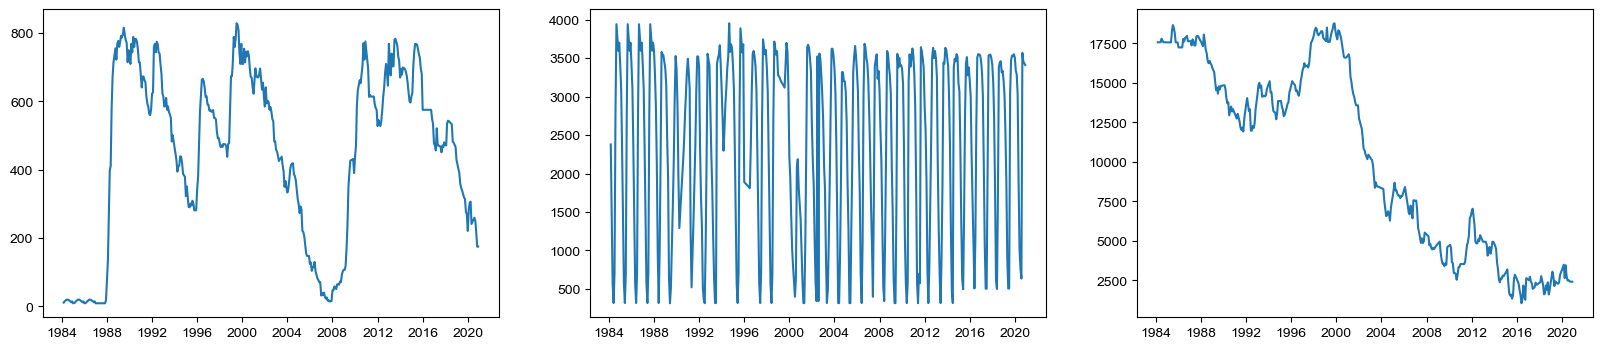

In [9]:
months = pd.date_range('1984-3-1','2020-12-31',freq='MS').values
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs = axs.ravel()

axs[0].plot(months, output_storage[output_id.index(1660)])
axs[1].plot(months, output_storage[output_id.index(1502)])
axs[2].plot(months, output_storage[output_id.index(809)])